In [1]:
from utils import *



[2024-01-30 17:47:00,193 DEBUG] [matplotlib.__init__.wrapper] matplotlib data path: /Users/williamfoote/Documents/GitHub/willybears_crystal_balls/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
[2024-01-30 17:47:00,196 DEBUG] [matplotlib.__init__.wrapper] CONFIGDIR=/Users/williamfoote/.matplotlib
[2024-01-30 17:47:00,197 DEBUG] [matplotlib.__init__.<module>] interactive is False
[2024-01-30 17:47:00,198 DEBUG] [matplotlib.__init__.<module>] platform is darwin
[2024-01-30 17:47:00,235 DEBUG] [matplotlib.__init__.wrapper] CACHEDIR=/Users/williamfoote/.matplotlib
[2024-01-30 17:47:00,236 DEBUG] [matplotlib.font_manager.font_manager._load_fontmanager] Using fontManager instance from /Users/williamfoote/.matplotlib/fontlist-v330.json
[2024-01-30 17:47:00,236 DEBUG] [matplotlib.font_manager.font_manager._load_fontmanager] Using fontManager instance from /Users/williamfoote/.matplotlib/fontlist-v330.json


In [2]:
sc = OAuth2(None, None, from_file = 'oauth2.json')


[2024-01-30 17:47:00,412 DEBUG] [yahoo_oauth.oauth.__init__] Checking 
[2024-01-30 17:47:00,413 DEBUG] [yahoo_oauth.oauth.token_is_valid] ELAPSED TIME : 4304969.117512941
[2024-01-30 17:47:00,413 DEBUG] [yahoo_oauth.oauth.token_is_valid] TOKEN HAS EXPIRED
[2024-01-30 17:47:00,413 DEBUG] [yahoo_oauth.oauth.refresh_access_token] REFRESHING TOKEN


In [7]:
gm = yfa.Game(sc, 'mlb')
leagues = gm.league_ids()

In [8]:
leagues

['308.l.212094',
 '422.l.117242',
 '422.l.120533',
 '431.l.1225',
 '431.l.21280',
 '431.l.21283',
 '431.l.4806']

# Get all fantasy football data using yfa api

In [4]:
gm = yfa.Game(sc, 'nfl')
leagues = gm.league_ids()
lg = gm.to_league('423.l.658258')
teamkey = lg.team_key()
team = lg.to_team(teamkey)
start_week = 14
week = 14

In [5]:
all_rosters = get_all_team_rosters(lg, week = week)

# Load in player projections from sleeper

In [1614]:
player_ids = pd.read_csv('player_ids.csv')
player_ids['sleeper_id'] = player_ids['sleeper_id'].astype('str')
player_ids['yahoo_id'] = player_ids['yahoo_id'].fillna(0).astype(int).astype('str')

## Get remaining projections

In [1615]:
stats = Stats()

# Example usage
season_type = 'regular'
year = 2023
end_week = 17

### Run the code

In [1616]:
combined_projections = get_stats_for_weeks(start_week, end_week, season_type, year, stat_type = 'projections')
combined_stats = get_stats_for_weeks(start_week, end_week, season_type, year, stat_type='stats')

# Create an imputation function

If a player doesn't have a full lineup, we should impute the empty spots with an average of the best available players on the waiver wire. To do this, we will pull the available players from yahoo, join this to the sleeper projections, group by position, and select the top n players to find the average of.

# Get the yahoo free agents

In [1617]:
free_agents = {}
positions = lg.positions()
positions_list = list(positions.keys())

for position in positions_list:
    if position not in ['BN', 'W/R/T', 'IR']:  # Exclude 'BN' (Bench) position
        # Get the list of free agents for the position
        agents = lg.free_agents(position)
        # Append each agent to the free_agents dictionary
        for agent in agents:
            free_agents[agent['player_id']] = agent

# Add players from waivers
waiver_players = lg.waivers()
for player in waiver_players:
    free_agents[player['player_id']] = player

# Convert to DataFrame
import pandas as pd
free_agents_df = pd.DataFrame.from_dict(free_agents, orient='index')
free_agents_df = free_agents_df.rename(columns={'player_id':'yahoo_id'})
free_agents_df['yahoo_id'] = free_agents_df['yahoo_id'].astype('str')

In [1618]:
# Merge yahoo free agents with id map to get possible matches with sleeper projections
yahoo_merged = free_agents_df.merge(player_ids[['sleeper_id', 'yahoo_id', 'yahoo_name']], on = 'yahoo_id', how = 'inner')

# Merge this with sleeper

In [1619]:
proj_col_to_select = ['sleeper_id', 'pts_std', 'pts_ppr', 'pts_half_ppr', 'week']
proj_subset = combined_projections[proj_col_to_select]

In [1620]:
free_agents_df = yahoo_merged.merge(proj_subset, on = 'sleeper_id', how = 'left')

### Now make the imputation function

In [1621]:
positions_of_interest = [key for key in positions.keys() if key not in ['BN', 'IR']]
# Example usage
scoring_type = 'pts_ppr'  # Choose 'pts_std', 'pts_ppr', or 'pts_half_ppr'
imputable_evs = calculate_top_n_averages(free_agents_df, scoring_type, positions_of_interest, n = 2)


# Merge the data together. First, merge to the player_ids file, then to the roster file above.

In [1622]:
merged = combined_projections.merge(player_ids[['sleeper_id', 'yahoo_id', 'yahoo_name']], on = 'sleeper_id', how = 'inner')

In [1623]:
final_merged = merged.merge(all_rosters, left_on = 'yahoo_id', right_on = 'player_id', how = 'right')

# Now that we have the merged data, look at the standings data

In [104]:
# Assuming lg.standings() returns the standings
standings = lg.standings()


In [107]:
# Convert standings to DataFrame
standings_df = pd.DataFrame(standings)

# Normalize the nested dictionaries in the 'outcome_totals' and 'streak' columns
# This will create separate columns for each key in these dictionaries
outcome_totals_df = pd.json_normalize(standings_df['outcome_totals'])
streak_df = pd.json_normalize(standings_df['streak'])

# Drop the original nested columns from standings_df
standings_df.drop(columns=['outcome_totals', 'streak'], inplace=True)

# Concatenate the flattened columns back into the original DataFrame
standings_df = pd.concat([standings_df, outcome_totals_df, streak_df], axis=1)
standings_df['team_id'] = standings_df['team_key'].str.extract(r'\.t\.(\d+)$')
standings_df['wins'] = standings_df['wins'].astype('int')
standings_df['losses'] = standings_df['losses'].astype('int')
standings_df['percentage'] = standings_df['percentage'].astype('float')
standings_df['points_for'] = standings_df['points_for'].astype('float')
standings_df['points_against'] = standings_df['points_against'].astype('float')
standings_df['rank'] = standings_df['rank'].astype('int')
standings_df['playoff_seed'] = standings_df['playoff_seed'].astype('int')
standings_df['value'] = standings_df['value'].astype('int')

# Load the matchups data

Get the remaining matchups in a dictionary of dictionaries. It will be len(dict) = how many weeks there are left.

This way, we only call the lg.matchups() once.

In [1657]:
rest_of_matchups_dict = {str(i):lg.matchups(week = i) for i in range(week, 15)}

# Process the season stats data

In [1658]:
# Example usage:
stats_subset = combined_stats[['sleeper_id', 'week', 'pts_std', 'pts_half_ppr', 'pts_ppr']][~combined_stats['pts_std'].isna() & ~combined_stats['sleeper_id'].str.startswith('TEAM_')]

# To get the mean and variance for standard points (pts_std)
result_std = calculate_dist_parameters(stats_subset, 'pts_std')

# For half PPR points (pts_half_ppr)
result_half_ppr = calculate_dist_parameters(stats_subset, 'pts_half_ppr')

# For PPR points (pts_ppr)
result_ppr = calculate_dist_parameters(stats_subset, 'pts_ppr')


# Now that we have the future and past data, we can join the two

### I. Next steps: 
#### 1. Join datasets

#### 2. optimize a lineup. Sort the players on a roster to have the highest EV points.

#### 3. Process: We have projected points, generate a random gamma number that simulates how many points they score. 

In [1660]:
p_and_s_merged = join_projections_and_stats(final_merged, combined_stats, scoring_type = 'pts_half_ppr')

# Set optimal lineups

In [1662]:
optimal_lineups_df = set_optimal_lineup(p_and_s_merged, lg.positions(), 'pts_half_ppr')


In [1664]:
cols_to_select = ['eligible_positions',
 'name',
 'optimal_position',
 'player_id',
 'std',
 'selected_position',
 'sleeper_id',
 'status',
 'team_id',
 'team_name',
 'week',
 'yahoo_id',
 'pts_half_ppr',
 'pts_ppr',
 'pts_std']

week_df = optimal_lineups_df[cols_to_select]

# Create a function to expand the eligible positions into separate rows
def expand_eligible_positions(row):
    return [(row['std'], pos) for pos in row['eligible_positions']]

# Apply the function and create a new DataFrame
expanded_rows = week_df[week_df['optimal_position'] == 'Bench'].apply(expand_eligible_positions, axis=1).explode()
expanded_df = pd.DataFrame(expanded_rows.tolist(), columns=['std', 'position'])

# Filter for specific positions
filtered_df = expanded_df[expanded_df['position'].isin(positions_of_interest)]

# Group by position and calculate the mean standard deviation
imputable_stds = filtered_df.groupby('position')['std'].mean()

# Build the simulation

# Building the sim out

In [1665]:
required_positions = {key: value['count'] * value['is_starting_position'] for key, value in positions.items() if value['is_starting_position']}

In [1666]:
# np.random.seed(248)

# Example usage
scoring_type = 'pts_half_ppr'
team_points = simulate_week_points(week_df, week, imputable_evs, imputable_stds,
                                   scoring_type='pts_half_ppr', n=3, required_positions=required_positions)


In [1667]:
# Example usage
scoring_type = 'pts_half_ppr'
updated_standings = simulate_week_matchups(week_df, week, scoring_type, standings_df, rest_of_matchups_dict, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions)

In [1668]:
# Example usage
num_playoff_teams = 6
# Assuming 'initial_week_df' and 'initial_standings_df' are defined and 'lg' is the league object
final_regular_season_standings = simulate_end_of_regular_season(week_df, standings_df, scoring_type, rest_of_matchups_dict, num_playoff_teams, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions, week=week)


In [1669]:
final_regular_season_standings

,team_key,name,rank,playoff_seed,points_for,points_against,wins,losses,ties,percentage,type,value,team_id,made_playoffs
0,423.l.658258.t.1,Pancake Man,1,1,1455.865,1328.370,10,4,0,0.714,win,1,1,1
1,423.l.658258.t.10,The William Bears,2,2,1397.745,1178.705,9,5,0,0.643,loss,1,10,1
3,423.l.658258.t.8,Slim Pickens (,3,3,1433.643,1343.859,8,6,0,0.571,win,1,8,1
2,423.l.658258.t.9,Deevi from New Delhi,4,4,1410.459,1322.623,8,6,0,0.571,loss,1,9,1
6,423.l.658258.t.4,Joey sux I hate Joey,5,5,1334.445,1384.325,8,6,0,0.571,win,1,4,1
7,423.l.658258.t.5,Cleveland Downs,6,6,1281.101,1320.518,8,6,0,0.571,win,1,5,1
5,423.l.658258.t.3,Tailgate szn,7,7,1396.230,1434.685,7,7,0,0.500,loss,1,3,0
4,423.l.658258.t.6,Revenge szn ong,8,8,1381.658,1292.741,7,7,0,0.500,loss,1,6,0
8,423.l.658258.t.12,Pietism,9,9,1176.160,1236.625,6,8,0,0.429,loss,1,12,0
10,423.l.658258.t.7,We are the JIMBO,10,10,1157.197,1304.981,5,9,0,0.357,win,1,7,0


## Run bracket

In [1670]:

# Example usage
scoring_type = 'pts_half_ppr'
final_brackets, final_standings_playoffs = simulate_playoffs_12(week_df, 15, scoring_type=scoring_type, final_standings=final_regular_season_standings,
                                                                 imputable_evs=imputable_evs, imputable_stds=imputable_stds, required_positions=required_positions,n=3, num_playoff_teams=6)


# Finally, running the actual simulations

In [1672]:
# np.random.seed(248)
regular_season_stats_df, playoff_stats_df = run_simulations(week_df, 1000, scoring_type, standings_df, rest_of_matchups_dict)
regular_season_stats_df['made_playoffs'] = regular_season_stats_df['made_playoffs'] * 100
playoff_stats_df['won_championship'] = playoff_stats_df['won_championship'] * 100
playoff_stats_df['is_toilet_loser'] = playoff_stats_df['is_toilet_loser'] * 100

In [ ]:
regular_season_stats_df['name'] = regular_season_stats_df.apply(
    lambda row: row['name'] if row['team_id'] == '10' else f"Team {row['team_id']}", axis=1
)
playoff_stats_df['team_name'] = playoff_stats_df.apply(
    lambda row: row['team_name'] if row['team_id'] == '10' else f"Team {row['team_id']}", axis=1
)

In [1644]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
regular_season_stats_df

,team_id,name,playoff_seed,points_for,points_against,wins,losses,ties,percentage,made_playoffs,best_playoff_seed,worst_playoff_seed
10,10,The William Bears,1.722,1432.159,1166.482,9.529,4.471,0.000,0.681,100.000,1,3
1,1,Pancake Man,1.646,1438.900,1331.178,9.446,4.554,0.000,0.675,100.000,1,3
9,9,Deevi from New Delhi,3.325,1420.244,1315.582,8.558,5.442,0.000,0.611,100.000,1,6
3,3,Tailgate szn,5.392,1399.038,1417.720,7.554,6.446,0.000,0.540,75.000,3,8
5,5,Cleveland Downs,6.625,1288.646,1334.274,7.529,6.471,0.000,0.538,47.500,4,9
4,4,Joey sux I hate Joey,6.605,1322.222,1418.739,7.471,6.529,0.000,0.534,40.700,4,8
6,6,Revenge szn ong,5.906,1395.414,1300.286,7.471,6.529,0.000,0.534,54.300,3,8
8,8,Slim Pickens (,4.785,1426.602,1353.644,7.442,6.558,0.000,0.532,82.500,3,8
12,12,Pietism,8.994,1212.107,1218.309,6.419,7.581,0.000,0.459,0.000,8,9
7,7,We are the JIMBO,10.526,1162.345,1320.049,4.544,9.456,0.000,0.325,0.000,10,12


In [1645]:
playoff_stats_df.sort_values(by = ['won_championship', 'is_toilet_loser'], ascending=[False, True])

,team_id,team_name,final_placement,won_championship,is_toilet_loser,best_finish,worst_finish,simulations_count
10,10,The William Bears,2.397,35.500,0.000,1,6,1000
1,1,Pancake Man,2.749,19.700,0.000,1,6,1000
4,4,Joey sux I hate Joey,6.137,10.700,1.200,1,12,1000
9,9,Deevi from New Delhi,3.859,9.700,0.000,1,6,1000
3,3,Tailgate szn,5.210,8.800,2.100,1,12,1000
8,8,Slim Pickens (,4.929,7.400,2.200,1,12,1000
6,6,Revenge szn ong,6.280,5.100,5.800,1,12,1000
5,5,Cleveland Downs,6.799,3.100,6.500,1,12,1000
12,12,Pietism,9.412,0.000,17.000,7,12,1000
2,2,Big-Ten Bitches,9.924,0.000,20.000,7,12,1000


# Make charts!

We want to look at playoff likelihood, championship likelihood, toilet bowl likelihood, chance of championship given they make the playoffs, chance of toilet bowl given they miss the playoffs. most important matchup -- which matchup has the biggest effect on P(playoffs|win/loss)--will this always be the current matchup? projected playoff seed. violin plot of playoff seeds by team. 

## Create color map for each team

In [144]:
# Assuming 'df' is your DataFrame and 'team_name' is the column with team names
team_names = playoff_stats_df['team_name'].unique()

# Generate a color palette with the same number of colors as teams
palette = sns.color_palette("tab10", n_colors=len(team_names))  # 'tab10' or any other palette

# Create a dictionary to map team names to colors
color_map = dict(zip(team_names, palette))

NameError: name 'playoff_stats_df' is not defined

# Playoff chances by team

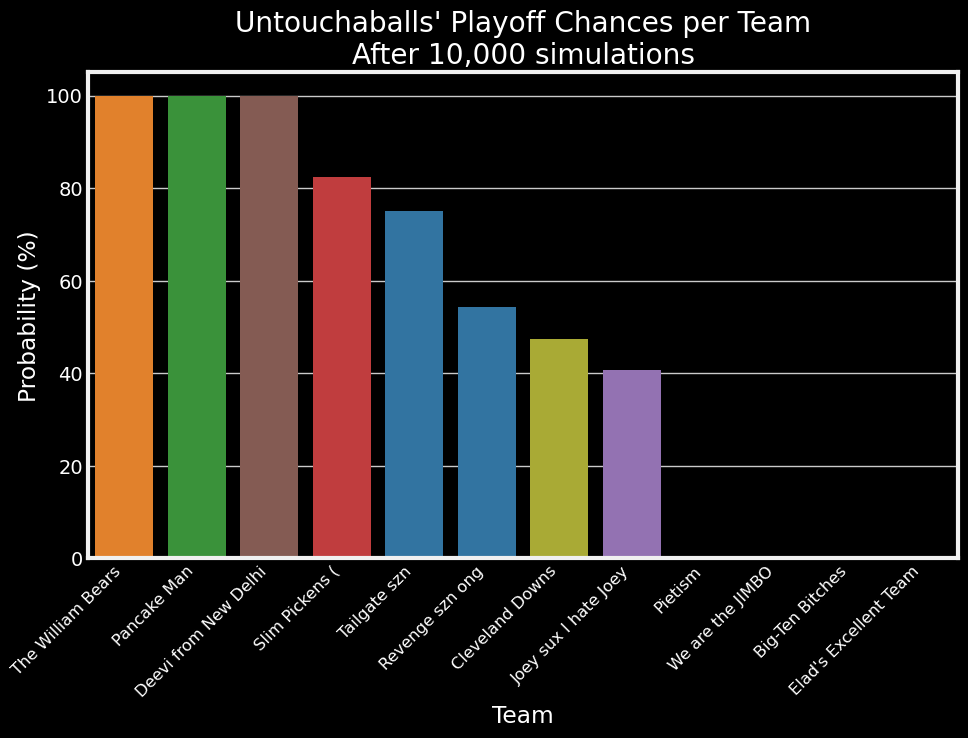

In [1647]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='made_playoffs', data=regular_season_stats_df.sort_values('made_playoffs', ascending = False),
            palette=color_map, hue = 'name')
plt.title("Untouchaballs' Playoff Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()


# Championship Chances by Team

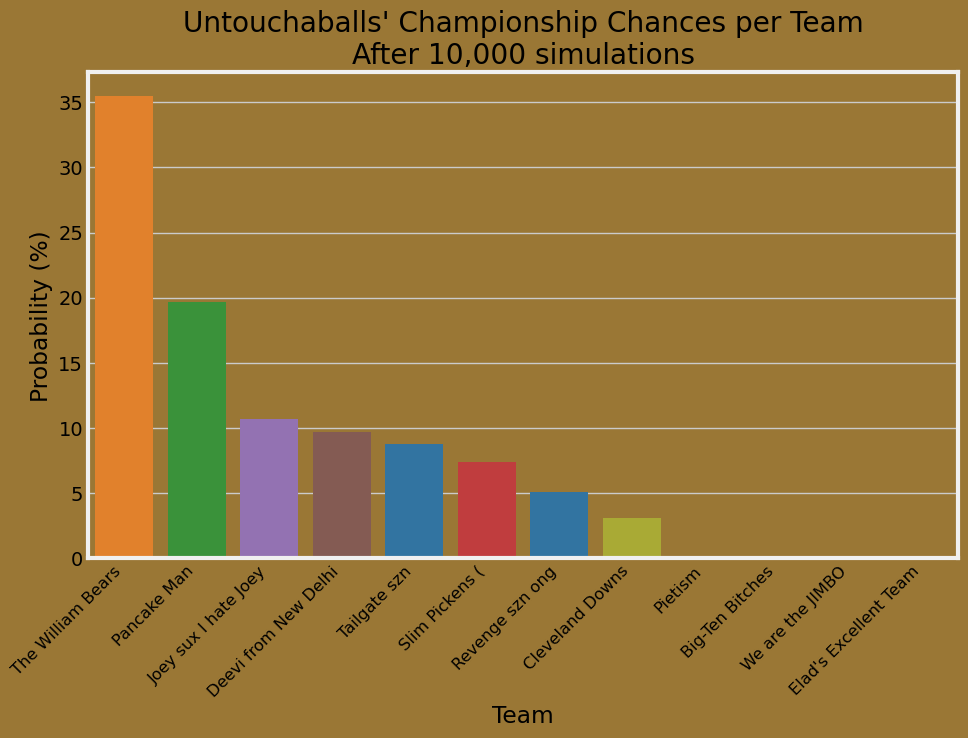

In [1648]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = '#9A7735'
plt.rcParams['figure.facecolor'] = '#9A7735'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='won_championship', data=playoff_stats_df.sort_values(by = ['won_championship', 'is_toilet_loser'],
                                                                                   ascending=[False, True]),
             palette=color_map, hue = 'team_name')
plt.title("Untouchaballs' Championship Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()


# Toilet Bowl Chances

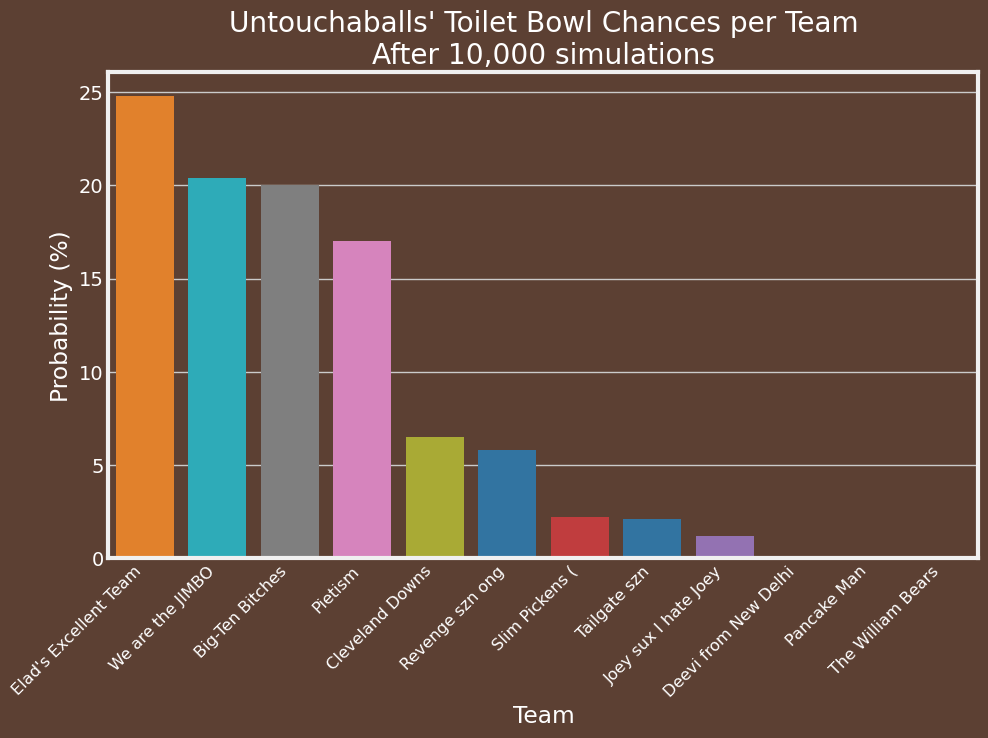

In [1650]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = '#5C4033'
plt.rcParams['figure.facecolor'] = '#5C4033'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='is_toilet_loser', data=playoff_stats_df.sort_values(by = ['is_toilet_loser', 'won_championship'],
                                                                                   ascending=[False, True]),
             palette=color_map, hue = 'team_name')
plt.title("Untouchaballs' Toilet Bowl Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()


# How have playoff simulations changed over time?

Let's simulate simulating the season from week 1. Based on rosters back then and projections back then, what were the odds we all made the playoffs? Who's seen the biggest decrease since then.

In [1]:
all_rosters


NameError: name 'all_rosters' is not defined

# Versus the median?


In [7]:
all_matchups_dict = {str(i):lg.matchups(week = i) for i in range(1, 15)}


In [96]:
import pandas as pd
import numpy as np

def calculate_standings(all_matchups_dict):
    columns = ['team_id', 'wins', 'losses', 'ties', 'win_pct_raw',
               'wins_with_median', 'losses_with_median', 'ties_with_median',
               'wins_total_median', 'losses_total_median', 'ties_total_median',
               'win_pct_total_median', 'points_for', 'points_against']
    standings_df = pd.DataFrame(columns=columns).set_index('team_id')

    for week in range(1, 14):
        weekly_scores = {}
        for i in range(6):  # Assuming 6 matchups
            matchup_key = str(i)
            matchup = all_matchups_dict[str(week)]
            
            tm1 = matchup['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['0']['team'][0][1]['team_id']
            tm2 = matchup['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['1']['team'][0][1]['team_id']
            # Check if team id's are in the standings df
            if tm1 not in standings_df.index:
                standings_df.loc[tm1] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Initialize other columns as well
            if tm2 not in standings_df.index:
                standings_df.loc[tm2] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

            # Get points for each team in the matchup
            tm1_points = float(matchup['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['0']['team'][1]['team_points']['total'])
            tm2_points = float(matchup['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['1']['team'][1]['team_points']['total'])

            weekly_scores[tm1] = tm1_points
            weekly_scores[tm2] = tm2_points

            # Compare points and update standings
            if tm1_points > tm2_points:
                standings_df.loc[tm1, 'wins'] += 1
                standings_df.loc[tm2, 'losses'] += 1
            elif tm2_points > tm1_points:
                standings_df.loc[tm2, 'wins'] += 1
                standings_df.loc[tm1, 'losses'] += 1
            else:  # In case of a tie
                standings_df.loc[tm1, 'ties'] += 1
                standings_df.loc[tm2, 'ties'] += 1

            # Update points for and against
            standings_df.loc[tm1, 'points_for'] += tm1_points
            standings_df.loc[tm1, 'points_against'] += tm2_points
            standings_df.loc[tm2, 'points_for'] += tm2_points
            standings_df.loc[tm2, 'points_against'] += tm1_points
                

        median_score = np.median(list(weekly_scores.values()))

        # Update standings based on median score
        for team_id, team_score in weekly_scores.items():
            if team_score > median_score:
                standings_df.loc[team_id, 'wins_with_median'] += 1
            elif team_score < median_score:
                standings_df.loc[team_id, 'losses_with_median'] += 1
            else:
                standings_df.loc[team_id, 'ties_with_median'] += 1

    # Calculate total wins, losses, ties including those with median
    for team_id in standings_df.index:
        standings_df.loc[team_id, 'wins_total_median'] = standings_df.loc[team_id, 'wins'] + standings_df.loc[team_id, 'wins_with_median']
        standings_df.loc[team_id, 'losses_total_median'] = standings_df.loc[team_id, 'losses'] + standings_df.loc[team_id, 'losses_with_median']
        standings_df.loc[team_id, 'ties_total_median'] = standings_df.loc[team_id, 'ties'] + standings_df.loc[team_id, 'ties_with_median']

        # Calculate win percentages
        total_games_raw = standings_df.loc[team_id, 'wins'] + standings_df.loc[team_id, 'losses'] + standings_df.loc[team_id, 'ties']
        total_games_median = standings_df.loc[team_id, 'wins_total_median'] + standings_df.loc[team_id, 'losses_total_median'] + standings_df.loc[team_id, 'ties_total_median']

        standings_df.loc[team_id, 'win_pct_raw'] = standings_df.loc[team_id, 'wins'] / total_games_raw if total_games_raw > 0 else 0
        standings_df.loc[team_id, 'win_pct_total_median'] = standings_df.loc[team_id, 'wins_total_median'] / total_games_median if total_games_median > 0 else 0

    return standings_df.reset_index()


In [166]:
median_standings_df = calculate_standings(all_matchups_dict)
merged_standings_df = standings_df[['team_id', 'name']].merge(median_standings_df, on = 'team_id')
# Calculate the difference in wins and losses against the median
merged_standings_df['wins_diff_median'] = merged_standings_df['wins_with_median'] - merged_standings_df['wins']
merged_standings_df['losses_diff_median'] = merged_standings_df['losses_with_median'] - merged_standings_df['losses']
# Sort the DataFrame first by 'win_pct_raw' and then by 'points_for', both in descending order
merged_standings_df = merged_standings_df.sort_values(by=['win_pct_raw', 'points_for'], ascending=[False, False])

# Apply dense ranking to the sorted DataFrame
merged_standings_df['rank_raw'] = merged_standings_df[['win_pct_raw', 'points_for']].apply(tuple,axis=1)\
             .rank(method='dense',ascending=False).astype(int)
# Repeat the process for rank with median
merged_standings_df['rank_median'] = merged_standings_df[['win_pct_total_median', 'points_for']].apply(tuple,axis=1)\
             .rank(method='dense',ascending=False).astype(int)
merged_standings_df['diff_rank'] = merged_standings_df['rank_raw'] - merged_standings_df['rank_median']

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/2972037937.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '66.08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  standings_df.loc[tm1, 'points_for'] += tm1_points
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/2972037937.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '58.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  standings_df.loc[tm1, 'points_against'] += tm2_points
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/2972037937.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6923076923076923' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

In [140]:
merged_standings_df.sort_values(by = 'win_pct_total_median', ascending = False)

,team_id,name,wins,losses,ties,win_pct_raw,wins_with_median,losses_with_median,ties_with_median,wins_total_median,losses_total_median,ties_total_median,win_pct_total_median,points_for,points_against,wins_diff_median,losses_diff_median,rank_raw,rank_median,diff_rank
1,10,The William Bears,9,4,0,0.692308,9,4,0,18,8,0,0.692308,1331.44,1067.20,0,0,2,1,1
0,1,Pancake Man,9,4,0,0.692308,8,5,0,17,9,0,0.653846,1344.96,1233.28,-1,1,1,2,-1
3,8,Slim Pickens (,7,6,0,0.538462,10,3,0,17,9,0,0.653846,1332.22,1255.50,3,-3,4,3,1
2,9,Deevi from New Delhi,8,5,0,0.615385,7,6,0,15,11,0,0.576923,1322.10,1221.20,-1,1,3,4,-1
5,3,Tailgate szn,7,6,0,0.538462,8,5,0,15,11,0,0.576923,1301.14,1323.78,1,-1,6,5,1
4,6,Revenge szn ong,7,6,0,0.538462,7,6,0,14,12,0,0.538462,1304.92,1207.34,0,0,5,6,-1
6,4,Joey sux I hate Joey,7,6,0,0.538462,6,7,0,13,13,0,0.500000,1222.94,1318.02,-1,1,7,7,0
7,5,Cleveland Downs,7,6,0,0.538462,5,8,0,12,14,0,0.461538,1195.70,1243.78,-2,2,8,8,0
8,12,Pietism,6,7,0,0.461538,5,8,0,11,15,0,0.423077,1130.26,1130.22,-1,1,9,9,0
9,2,Big-Ten Bitches,4,9,0,0.307692,6,7,0,10,16,0,0.384615,1221.38,1306.38,2,-2,10,10,0


/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/632830516.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='wins', data=merged_standings_df, palette=color_map)


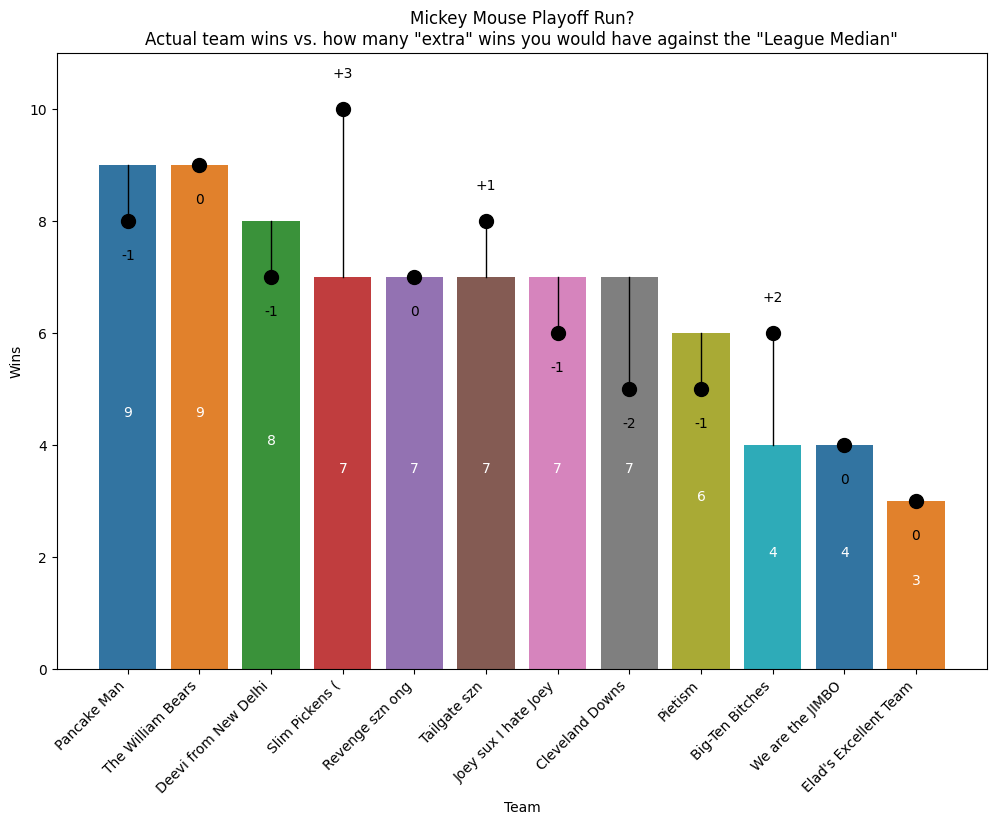

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'team_name' is the column with team names
team_names = merged_standings_df['name'].unique()

# Generate a color palette with the same number of colors as teams
palette = sns.color_palette("tab10", n_colors=len(team_names))  # 'tab10' or any other palette

# Create a dictionary to map team names to colors
color_map = dict(zip(team_names, palette))

# Calculate the maximum value for y-axis limit
max_adjusted_win = max(merged_standings_df['wins'] + merged_standings_df['wins_diff_median'])
y_axis_limit = max_adjusted_win + 1  # Adding 1 for additional space

plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='wins', data=merged_standings_df, palette=color_map)

# Adding points, lines, and labels
for i, row in merged_standings_df.iterrows():
    # Raw wins label at the middle of the bar
    plt.text(i, row['wins'] / 2, f"{row['wins']}", color='white', ha='center')

    # Point for adjusted wins
    adjusted_win = row['wins'] + row['wins_diff_median']
    plt.scatter(i, adjusted_win, color='black', s=100, zorder=3)

    # Line from bar top to the point
    plt.plot([i, i], [row['wins'], adjusted_win], color='black', linestyle='-', linewidth=1)

    # Label for adjusted wins
    win_diff_label = f"+{row['wins_diff_median']}" if row['wins_diff_median'] > 0 else f"{row['wins_diff_median']}"
    label_pos = adjusted_win + 0.5 if row['wins_diff_median'] > 0 else adjusted_win - 0.5
    plt.text(i, label_pos, win_diff_label, color='black', ha='center', va='bottom' if row['wins_diff_median'] > 0 else 'top')

plt.xticks(rotation=45, ha = 'right')
plt.ylim(0, y_axis_limit)  # Set y-axis limit
plt.xlabel('Team')
plt.ylabel('Wins')
plt.title('Mickey Mouse Playoff Run?\nActual team wins vs. how many "extra" wins you would have against the "League Median"')
plt.show()


/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/723130571.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='name', y='adjusted_diff_rank', data=merged_standings_df, palette=color_map)


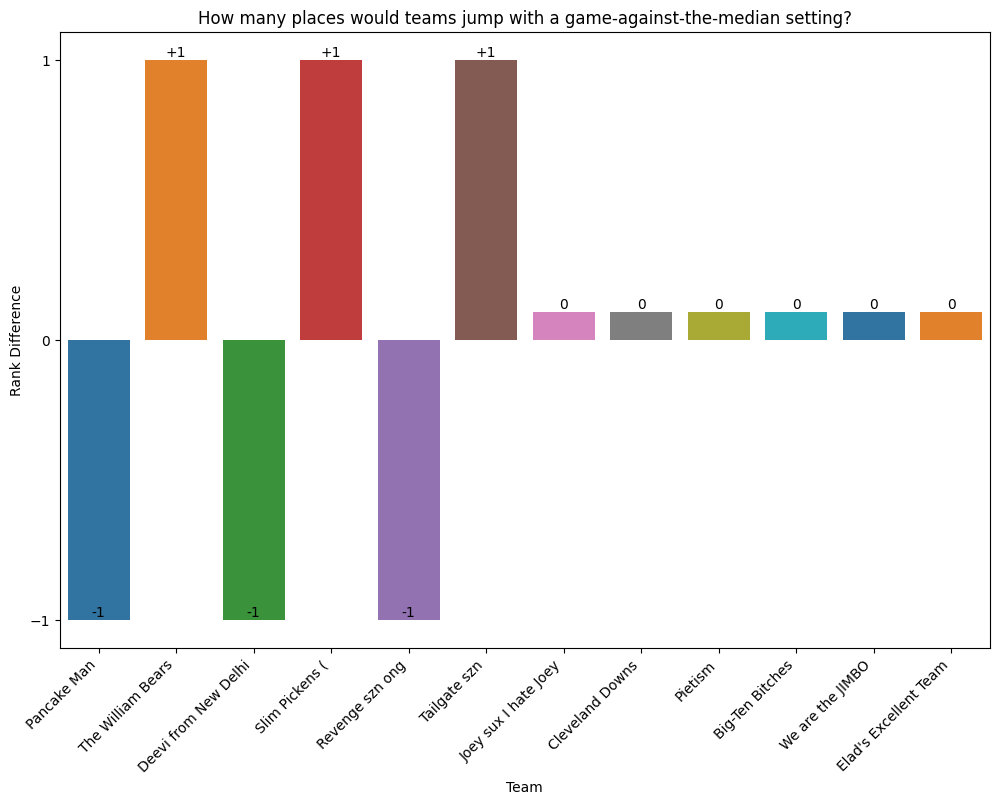

In [171]:
plt.figure(figsize=(12, 8))
# Adjust zero values to a small positive value for visibility
merged_standings_df['adjusted_diff_rank'] = merged_standings_df['diff_rank'].apply(lambda x: 0.1 if x == 0 else x)

# Plotting
barplot = sns.barplot(x='name', y='adjusted_diff_rank', data=merged_standings_df, palette=color_map)

plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(min(merged_standings_df['adjusted_diff_rank']), max(merged_standings_df['adjusted_diff_rank'])+1, 1.0))  # Set y-ticks to integer values
plt.xlabel('Team')
plt.ylabel('Rank Difference')
plt.title('How many places would teams jump with a game-against-the-median setting?')

# Adding labels on top of each bar
for i, row in merged_standings_df.iterrows():
    diff_rank_label = f"+{int(row['diff_rank'])}" if row['diff_rank'] > 0 else f"{int(row['diff_rank'])}"
    plt.text(i, row['adjusted_diff_rank'], diff_rank_label, color='black', ha='center', va='bottom')

plt.show()


/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_43458/1009615972.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='win_pct_total_median', data=sorted_df, palette=color_map)


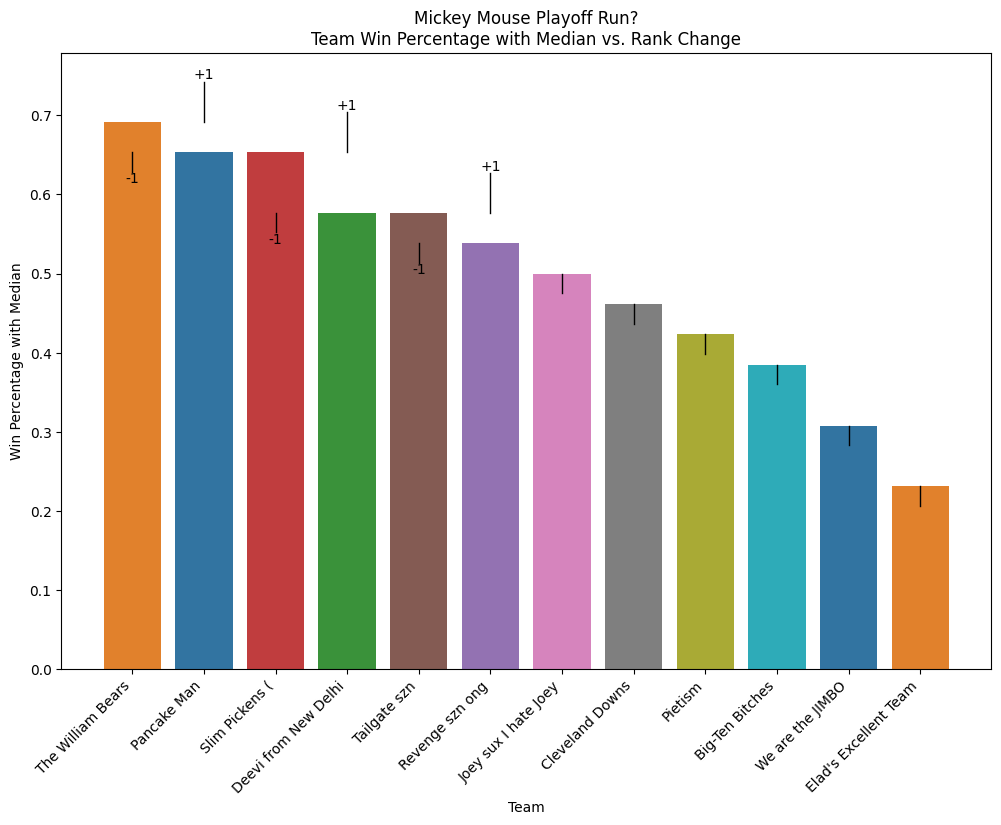

In [181]:
# Sort the DataFrame by 'rank_median' in descending order
sorted_df = merged_standings_df.sort_values(by='rank_median', ascending=True)

plt.figure(figsize=(12, 8))

# Bar plot for win percentages considering the median
sns.barplot(x='name', y='win_pct_total_median', data=sorted_df, palette=color_map)

# Adding lines and labels for rank difference
for i, row in sorted_df.iterrows():
    # Calculate the rank difference
    rank_diff = row['rank_raw'] - row['rank_median']

    # Determine the position for the end of the line
    line_end_pos = row['win_pct_total_median'] + (0.05 if rank_diff > 0 else -0.025)

    # Draw a line to signify rank difference
    plt.plot([i, i], [row['win_pct_total_median'], line_end_pos], color='black', linestyle='-', linewidth=1)

    # Label for rank difference
    if rank_diff != 0:
        rank_diff_label = f"+{int(rank_diff)}" if rank_diff > 0 else f"{int(rank_diff)}"
        plt.text(i, line_end_pos, rank_diff_label, color='black', ha='center', va='bottom' if rank_diff > 0 else 'top')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Team')
plt.ylabel('Win Percentage with Median')
plt.title('Mickey Mouse Playoff Run?\nTeam Win Percentage with Median vs. Rank Change')
plt.show()
